# Lab 5:  Pitch Detection in Audio 

In this lab, we will use numerical optimization to find the pitch and harmonics in a simple audio signal.  In addition to the concepts in the [gradient descent demo](./grad_descent.ipynb), you will learn to:
* Load, visualize and play audio recordings
* Divide audio data into frames
* Perform nested minimization

The ML method presented here for pitch detection is actually not a very good one.  As we will see, it is highly susceptible to local minima and quite slow.  There are several better [pitch detection algorithms](https://en.wikipedia.org/wiki/Pitch_detection_algorithm), mostly using frequency-domain techniques.  But, the method here will illustrate non-linear estimation well.

## Reading the Audio File

Python provides a very simple method to read a `wav` file in the `scipy.io.wavefile` package.  We first load that along with the other packages.

In [27]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In the github repository, you should find a file, [`viola.wav`](./viola.wav).  Download this file to your local directory.  Although the file is included in the github repository, you can find it along with many other audio samples in [CCRMA audio website](https://ccrma.stanford.edu/~jos/pasp/Sound_Examples.html). After you have downloaded the file, you can then read the file with the `read` command.  Print the sample rate in Hz, the number of samples in the file and the file length in seconds.

In [28]:
# Read the file
sr, y = read('viola.wav')

# Convert to floating point values so that compuations below do not overflow
y = y.astype(float)

# TODO:  Print sample rate, number of samples and file length in seconds.
print("Sample Rate:",sr,"Hz")
print("Number of samples:",y.shape[0])
print("Length of file: {:.3f} s".format(y.shape[0]/sr))

Sample Rate: 44100 Hz
Number of samples: 299350
Length of file: 6.788 s


You can then play the file with the following command.  You should hear the viola play a sequence of simple notes.

In [29]:
import IPython.display as ipd
ipd.Audio(y, rate=sr) # load a NumPy array

For the analysis below, it will be easier to re-scale the samples so that they have an average squared value of 1.  Find the `scale` value in the code below to do this.

In [30]:
# TODO
# scale = ...
# y = y / scale
scale = np.sqrt(np.sum((y/np.sqrt(len(y)))**2))
y = y / scale

## Dividing the Audio File into Frames

In audio processing, it is common to divide audio streams into short frames (typically between 10 to 40 ms long).  Since frames are often processed with an FFT, the frames are typically a power of two.  Analysis is then performed in the frames separately.  Given the vector `y`, create a `nfft x nframe` matrix `yframe` where 

    yframe[:,0] = samples y[k], k=0,...,nfft-1
    yframe[:,1] = samples y[k], k=nfft,...,2*nfft-1,
    yframe[:,2] = samples y[k], k=2*nfft,...,3*nfft-1,
    ...
    
You can do this with the `reshape` command with `order=F`. Zero pad `y` if the number of samples of `y` is not divisible by `nfft`.  Print the total number of frames as well as the length (in milliseconds) of each frame.

Note that in actual audio processing, the frames are typically overlapping and use careful windowing.  But, we will ignore that here for simplicity.

In [31]:
# Frame size
nfft = 1024

# TODO:
#  nframe = ...
#  yframe = ...
y_padded = np.pad(y, (0, nfft - y.shape[0] % 1024), 'constant')
nframe = y_padded.shape[0] / nfft
yframe = y_padded.reshape(nfft, int(nframe), order='F')
print("Total frames:", int(nframe))
duration = (nfft / sr)*1000
print("Length of each frame: {:.3f} ms".format(duration))

Total frames: 293
Length of each frame: 23.220 ms


Let `i0=10` and set `yi=yframe[:,i0]` be the samples of frame `i0`.  We will use this frame for most of the rest of the lab.  Plot the samples of `yi`.  Label the time axis in milliseconds (ms).

Text(0.5,0,'time in milliseconds (ms)')

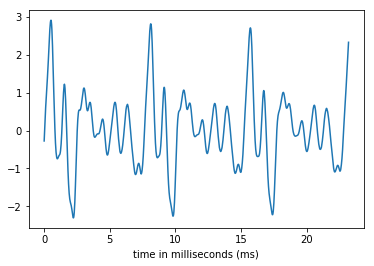

In [32]:
# Get samples from frame 10
i0 = 10
yi = yframe[:,i0]

# TODO:  Plot yi vs. time (in ms)
ms_time = np.linspace(0,1023,1024)/sr*1000
plt.plot(ms_time,yi)
plt.xlabel('time in milliseconds (ms)')

## Fitting a Multi-Sinusoid

A common model for audio samples, `yi[k]`, containing an instrument playing a single note is the multi-sinusoid model:

    yi[k] \approx yhati[k] = c + \sum_{j=0}^{nterms-1} a[j]*cos(2*np.pi*k*freq0*(j+1)/sr) 
                                                    +  b[j]*sin(2*np.pi*k*freq0*(j+1)/sr),
        
where `sr` is the sample rate.   The parameter `freq0` is called the fundamental frequency and the audio signal is modeled as being composed of sinusoids and cosinusoids with frequencies equal to integer multiples of the fundamental.  In audio processing, these terms are called *harmonics*.  In analyzing audio signals, a common goal is to determine both the fundamental frequency `freq0` (the pitch of the audio) as well as the coefficients of the harmonics,

    beta = (c, a[0], ..., a[nterms-1], b[0], ..., b[nterms-1]).
    
To find the parameters, we will fit the mean squared error loss function:

    mse(freq0,beta) := 1/N * \sum_k (yi[k] - yhati[k])**2,   N = len(yi).
    
In practice, a separate model would be fit for each audio frame.  But, in this lab, we will mostly look at a single frame.
    
### Nested Minimization
    
We will perform the minimization of `mse` in a nested manner:  First, given a fundamental frequency `freq0`, we minimize over the coefficients `beta`.  Call this minimum `mse1`:

    mse1(freq0) := min_beta mse(freq0,beta)

Importantly, this minimizaiton can be performed by least-squares.  Then, we find the fundamental frequency `freq0` by minimizing `mse1`:

    min_{freq0} mse1(freq0) 
    
We will use gradient-descent minimization with `mse1(freq0)` as the objective function.  This form of *nested* minimization is commonly used whenever we can minimize over one set of parameters easily given the other.

## Setting Up the Objective Function

We will use the class `AudioFitFn` below to perform the two-part minimization.  Complete the `feval` method in the class.  The method should take the argument `freq0` and perform the minimization of the MSE over `beta`.  Specifically, fill the code in `feval` to perform the following:
* Construct a matrix, `A` such that `yhati = A*beta`.  
* Find `betahat` with the `np.linalg.lstsq()` method using the matrix `A` and the samples `self.yi`.  This is simpler than constructing a linear regression object.  
* Compute and store the estimate `self.yhati = A.dot(betahat)`.
* Compute the `mse1`, the minimum MSE, by comparing `self.yhati` and `self.yi`.
* For now, set the gradient to `mse1_grad=0`.  We will fill this part in later.  
* Return `mse1` and `mse1_grad`.

In [33]:
class AudioFitFn(object):
    def __init__(self,yi,sr=44100,nterms=8):
        """
        A class for fitting 
        
        yi:  One frame of audio
        sr:  Sample rate (in Hz)
        nterms:  Number of harmonics used in the model (default=8)
        """
        self.yi = yi
        self.sr = sr
        self.nterms = nterms
                
    def feval(self,freq0):
        """
        Optimization function for audio fitting.  Given a fundamental frequency, freq0, the 
        method performs a least squares fit for the audio sample using the model:
        
        yhati[k] = c + \sum_{j=0}^{nterms-1} a[j]*cos(2*np.pi*k*freq0*(j+1)/sr) 
                                          +  b[j]*sin(2*np.pi*k*freq0*(j+1)/sr)
        
        The coefficients beta = [c,a[0],...,a[nterms-1],b[0],...,b[nterms-1]] 
        are found by least squares.

        Returns:
        
        mse1:   The MSE of the best least square fit.
        mse1_grad:  The gradient of mse1 wrt to the parameter freq0
        """
        
        # TODO   
        # TODO Write code to find optimal beta to minimize MSE and find minimal MSE with this beta
        # ...
        # mse1 = ...
        cos_vals = np.zeros([len(self.yi),self.nterms])
        sin_vals = np.zeros([len(self.yi),self.nterms])
        for k in range(len(self.yi)):
            for j in range(self.nterms):
                cos_vals[k,j] = np.cos(2*np.pi*k*freq0*(j+1)/self.sr)
                sin_vals[k,j] = np.sin(2*np.pi*k*freq0*(j+1)/self.sr)
        A = np.column_stack((np.ones(len(self.yi),), cos_vals, sin_vals))
        betahat = np.linalg.lstsq(A,self.yi)
        self.yhati = A.dot(betahat[0])
        mse1 = np.mean((self.yi-self.yhati)**2)
    
        # Compute the gradient wrt to freq0 
        dcos_vals = np.zeros([len(self.yi),self.nterms])
        dsin_vals = np.zeros([len(self.yi),self.nterms])
        for k in range(len(self.yi)):
            for j in range(self.nterms):
                dcos_vals[k,j] = np.sin(-2*np.pi*k*freq0*(j+1)/self.sr)*(2*np.pi*k*(j+1)/self.sr)
                dsin_vals[k,j] = np.cos(2*np.pi*k*freq0*(j+1)/self.sr)*(2*np.pi*k*(j+1)/self.sr)
        A_grad = np.column_stack((np.zeros(len(self.yi),), dcos_vals, dsin_vals))
        self.yhati_grad = A_grad.dot(betahat[0])
        mse1_grad = np.mean(2*(self.yhati-self.yi)*self.yhati_grad)
        
        return mse1, mse1_grad

Instantiate an object, `audio_fn` from the class `AudioFitFn` with the samples `yi`.  Then, using the `feval` method, compute and plot `mse1` for values `freq0` in the range of 0 to 500 Hz with a step size of 0.5Hz.  You should see a minimum around `freq0 = 131` Hz, but there are several other local minima.  

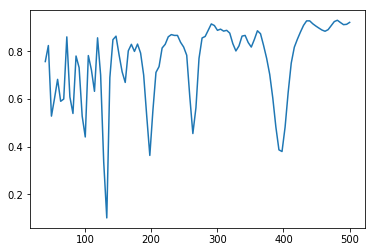

In [34]:
# TODO
audio_fn = AudioFitFn(yi)
freq0 = np.linspace(40,500,100)
mse1 = np.zeros([len(freq0)])
for i,f0 in enumerate(freq0):
    mse1[i], _ = audio_fn.feval(f0)
plt.plot(freq0,mse1)

Determine and print the value of `freq0` that achieves the minimum `mse1`.  Also, plot the estimated function `audio_fn.yhati` for that `freq0` along with the original samples `yi`.

Frequency of minimum MSE 132.929292929 Hz


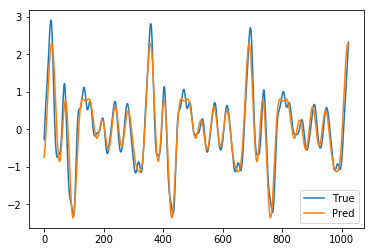

In [35]:
min_freq = freq0[np.argmin(mse1)]
print("Frequency of minimum MSE", min_freq, 'Hz')
audio_fn.feval(min_freq)
plt.plot(yi, label="True")
plt.plot(audio_fn.yhati, label="Pred")
plt.legend()

## Computing the Gradient

The above method found the estimate for `freq0` by performing a search over 100 different frequency values and selecting the frequency value with the lowest MSE.  We now see if we can estimate the frequency with gradient descent minimization of the MSE.  We first need to modify the `feval` method in the `AudioFitFn` class above to compute the gradient.  Some elementary calculus (see the homework), shows that 

    dmse1(freq0)/dfreq0 = dmse(freq0,betahat)/dfreq0
   
So, we just need to evaluate the partial derivative of `mse = np.mean((yi-yhati)**2)` with respect to the parameter `freq0` holding the parameters `beta=betahat`.  Modify the `feval` method above to compute the gradient and return the gradient in `mse1_grad`.  



Now, test the gradient by taking two close values of `freq0`, say `freq0_0` and `freq0_1` and verifying that first-order approximation holds.

In [36]:
# TODO
freq0_0 = freq0[20]
freq0_1 = freq0_0 + 1e-6

f00, f00_g = audio_fn.feval(freq0_0)
f01, f01_g = audio_fn.feval(freq0_1)

print("f01                    :", f01)
print("f00 + f00_grad(w01-w00):", f00 + f00_g * (freq0_1 - freq0_0))

f01                    : 0.100453487293
f00 + f00_grad(w01-w00): 0.100453487293


## Run the Optimizer

We cut and paste the optimizer from the [gradient descent demo](./grad_descent.ipynb).

In [37]:
def grad_opt_adapt(feval, winit, nit=1000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    
    Returns:
    w:   Final estimate for the optimal
    f0:  Function at the optimal
    """
    
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval(w0)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'w': [], 'f': []}

    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*fgrad0

        # Evaluate the test point by computing the objective function, f1,
        # at the test point and the predicted decrease, df_est
        f1, fgrad1 = feval(w1)
        df_est = fgrad0*(w1-w0)
        
        # Check if test point passes the Armijo rule
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2            
            
        # Save history
        hist['f'].append(f0)
        hist['lr'].append(lr)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'lr', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist


Now, run the optimizer with the feval function with a starting estimate for freq0 = 130 Hz.  Use `lr_init=1e-3` and `f0_init=130`. Print the final frequency estimate.  Also, print the [midi number](https://newt.phys.unsw.edu.au/jw/notes.html) of the estimated frequency:

     midi_num = 12*log2(freq/440 Hz) + 69
     
If the note was exactly a musical note, `midi_num` should be an integer.  But you will see that the frequency does not exactly lie on a note since the pitch in a viola bends around the note.

In [48]:
# TODO

f0_init = 130
w0_opt, func0_opt, f0_hist = grad_opt_adapt(audio_fn.feval, f0_init, nit=1000, lr_init=1e-3)
print("Final frequency estimate:", w0_opt)
midi_num_0 = 12*np.log2(w0_opt/440) + 69

print("midi number:",midi_num_0)

Final frequency estimate: 131.528923317
midi number: 48.0945187256


Plot the MSE as a function of the iteration. You should tell whether you gradient algorithm has converged. If not, you may need to adjust the number of iterations.

Text(0,0.5,'Loss')

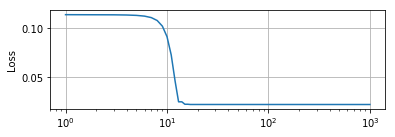

In [46]:
nit=1000
t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogx(t, f0_hist['f'])
plt.grid()
plt.ylabel('Loss')

Compare your solution of f0_min with the one obtained using exhaustive search. You may notice a slight difference. Explain why and also which solution is likely to be correct?

Answer: the new f0_min is 131.528923317, and the one obtained using exhaustive search is 132.9292929. There does exist a slight difference. I think the latter is likely to be correct since it has an adaptive step size.

Now, repeat with an initial frequency of 200 Hz.  Print the final estimated frequency.  Also plot the MSE per iteration on the same graph as the MSE per iteration with the initial condition = 130 Hz.  

Final frequency estimate: 197.872343473
MIDI number: 55.1647974948


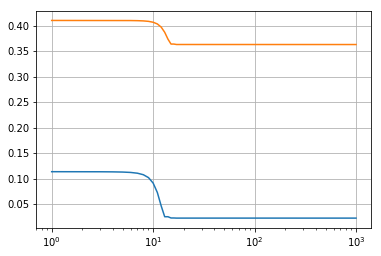

In [49]:
# TODO
f1_init = 200
w1_opt, func1_opt, f1_hist = grad_opt_adapt(audio_fn.feval,f1_init, nit=1000, lr_init=1e-3)
print("Final frequency estimate:", w1_opt)
midi_num_1 = 12*np.log2(w1_opt/440) + 69
print("MIDI number:", midi_num_1)
 
plt.semilogx(t,f0_hist['f'])
plt.semilogx(t,f1_hist['f'])
plt.grid()
plt.show()

Did you get the same solution as when you used an initial solution of 130 Hz? Why?

Answer: NO. Because once we change our initial frequency, the result is partially optimal, not global optimal.

## More Fun

While the above method does not work very well, there are many good approaches.  For one thing, we can obtain a good initial condition using an FFT of the frame.  The FFT is used in many pitch detection methods.  More difficult problems include multi-tone detection, chord detection and instrument separation.  A useful python library that contains all sorts of interesting audio analysis tools in the [librosa package](https://librosa.github.io/librosa/).